# SpeX Merging Orders Example

Last updated: November 2025

This notebook demonstrates how to merge multi-order spectra from SpeX observations into a single, continuous spectrum. This is particularly useful for SXD and LXD modes where the spectrum is split across multiple echelle orders that overlap in wavelength.

## Overview

When observing with SpeX in cross-dispersed modes (SXD, LXD), the spectrum is recorded in multiple echelle orders. Each order covers a different wavelength range, with some overlap between adjacent orders. The `merge` function:

1. Loads a multi-order spectrum from a FITS file
2. Identifies overlapping wavelength regions between orders
3. Optimally combines the overlapping regions based on signal-to-noise
4. Creates a single, continuous spectrum

## When to use merging

- **SXD mode**: 6-7 orders covering ~0.8-2.4 µm
- **LXD mode**: Multiple orders covering ~2.2-5.5 µm
- After combining and telluric correction
- When you need a single continuous spectrum for analysis

## Steps in this notebook:

1. Import packages and set up paths
2. Load a telluric-corrected multi-order spectrum  
3. Merge the orders into a single spectrum
4. Visualize the merged spectrum


In [1]:
# ============================================================================
# IMPORT PACKAGES
# ============================================================================
import pyspextool as ps
import os
import numpy as np
import matplotlib.pyplot as plt

# Display pyspextool package information
help(ps)

Help on package pyspextool:

NAME
    pyspextool

DESCRIPTION
    PySpexTool is a package intended to contain core functionality and some
    common tools needed for performing reduction for SpeX instrument in
    Python.

PACKAGE CONTENTS
    batch (package)
    combine (package)
    config
    extract (package)
    fit (package)
    io (package)
    merge (package)
    plot (package)
    pyspextoolerror
    setup_utils
    telluric (package)
    utils (package)

FILE
    /Users/ctheissen/repos/pyspextool/src/pyspextool/__init__.py




## Setup Paths and Configuration

We'll use an example spectrum from the test data. This could be from SXD or LXD mode - both produce multi-order spectra that can be merged.

In [2]:
# ============================================================================
# CONFIGURATION - Define paths and parameters
# ============================================================================

# Determine the installation path
file_base = ps.__file__.split('/src/')[0]
topbase   = os.getenv("HOME")

# Select which mode to demonstrate (change as needed)
# Options: 'spex-SXD', 'spex-LXD', 'uspex-SXD', 'uspex-LXD'
instrument_mode = 'spex-LXD'

# Paths to data
proc_path = file_base + f'/tests/test_data/processed/{instrument_mode}/proc/'
qa_path   = topbase + f'/test_pyspextool/test_data/processed/{instrument_mode}/qa/'

# Create QA output directory if it doesn't exist
if not os.path.exists(qa_path):
    os.makedirs(qa_path)
    print(f'Created QA directory: {qa_path}')

# Look for a telluric-corrected combined spectrum
# These files typically have 'calspec' in the name
import glob
calspec_files = glob.glob(proc_path + 'calspec*.fits')

if calspec_files:
    input_file = calspec_files[0]
    print(f'Found telluric-corrected spectrum: {os.path.basename(input_file)}')
else:
    # Fall back to combined spectrum if no telluric-corrected file exists
    combspec_files = glob.glob(proc_path + 'combspec*.fits')
    if combspec_files:
        input_file = combspec_files[0]
        print(f'Using combined spectrum: {os.path.basename(input_file)}')
    else:
        print('No suitable multi-order spectrum found in', proc_path)
        print('Please run one of the reduction notebooks first.')
        input_file = None

Found telluric-corrected spectrum: calspec6-9.fits


## Initialize pySpextool

Set up the pySpextool environment with paths for processed data and QA outputs.

In [3]:
# ============================================================================
# INITIALIZE PYSPEXTOOL
# ============================================================================

# Extract instrument name from mode string
instrument = instrument_mode.split('-')[0]  # 'spex' or 'uspex'

ps.pyspextool_setup(
    instrument,
    proc_path=proc_path,  # Where input/output spectra are located
    qa_path=qa_path,      # Where to save QA plots
    verbose=True,         # Print informational messages
    qa_show=True,         # Display QA plots
    qa_write=True,        # Save QA plots to disk
    qa_showblock=True     # Wait for user to close QA plots
)

INFO: pySpextool Setup
----------------------

DEBUG:Logger level: DEBUG
INFO: Verbose set to True. 
 Logging level set to INFO
/Users/ctheissen/repos/pyspextool/src/pyspextool/io/read_instrument_file.py:24: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  labels, vals = np.loadtxt(
/Users/ctheissen/repos/pyspextool/src/pyspextool/setup_utils.py:438: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the p

## Merge the Orders

The `ps.merge.merge()` function takes a multi-order spectrum and combines overlapping orders into a single continuous spectrum. 

### How it works:

1. **Load the spectrum**: Reads the multi-order FITS file
2. **Identify overlaps**: Finds wavelength regions where orders overlap
3. **Weight by S/N**: In overlap regions, weights each order by its signal-to-noise ratio
4. **Smooth transition**: Creates smooth transitions between orders
5. **Write output**: Saves the merged spectrum to a new FITS file

### Parameters:

- `file`: Input FITS file containing multi-order spectrum
- `outputfile_root`: Root name for output file (will append '_merged.fits')
- `merge_apertures`: Which apertures to merge (None = all apertures)
- `verbose`, `qa_show`, `qa_write`: Control output and QA plots


INFO: Order Merging
--------------------

INFO: Loading the spectra.
INFO: There are 1 apertures in this file.
INFO: Merging apertures 1.



Merging orders from: calspec6-9.fits
Output will be saved as: calspec6-9_merged.fits



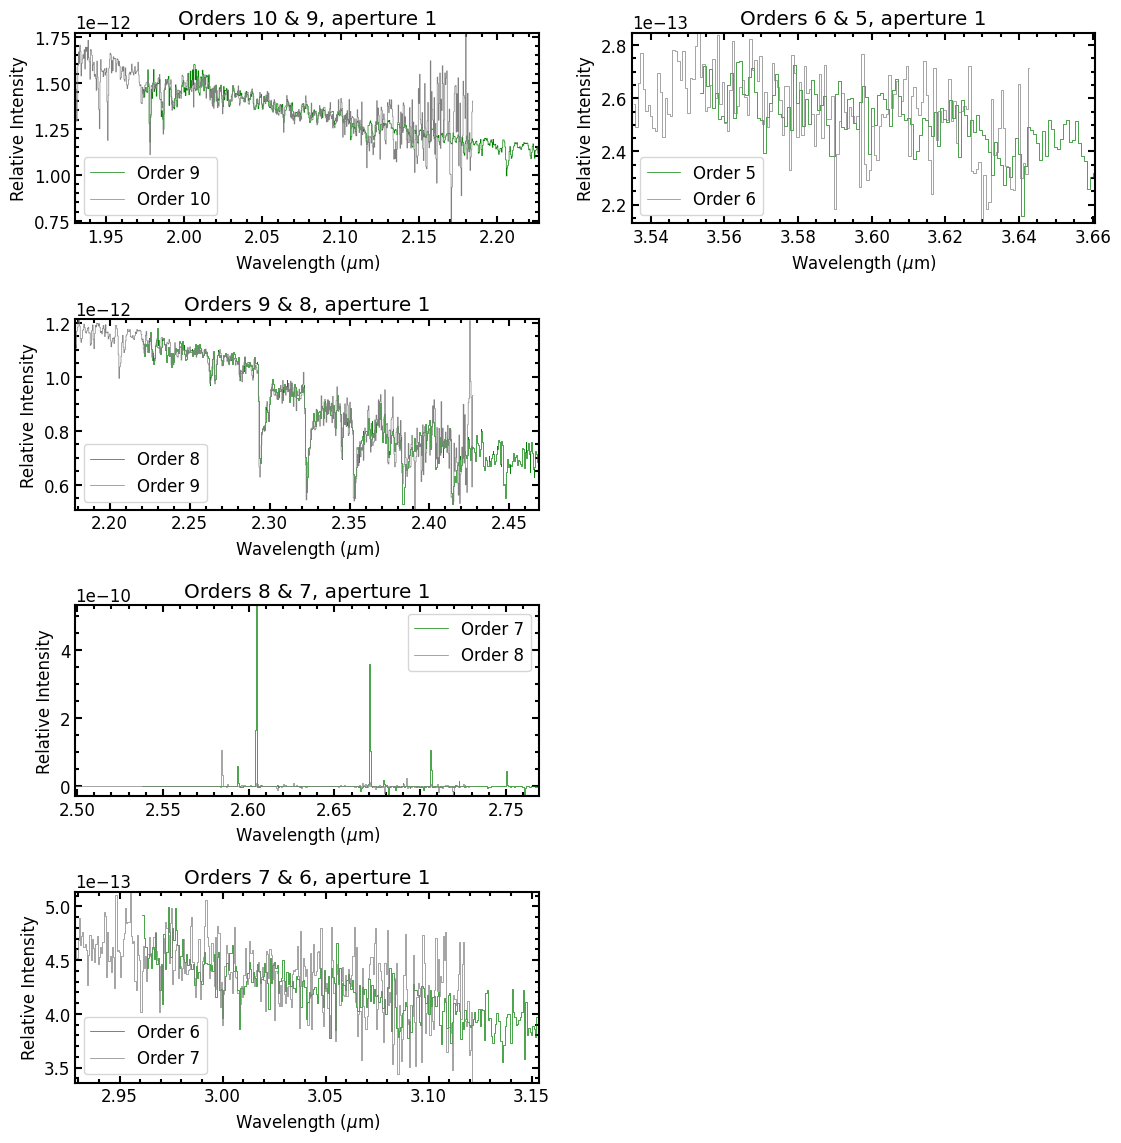

INFO: Wrote file calspec6-9_merged.fits to the proc directory.


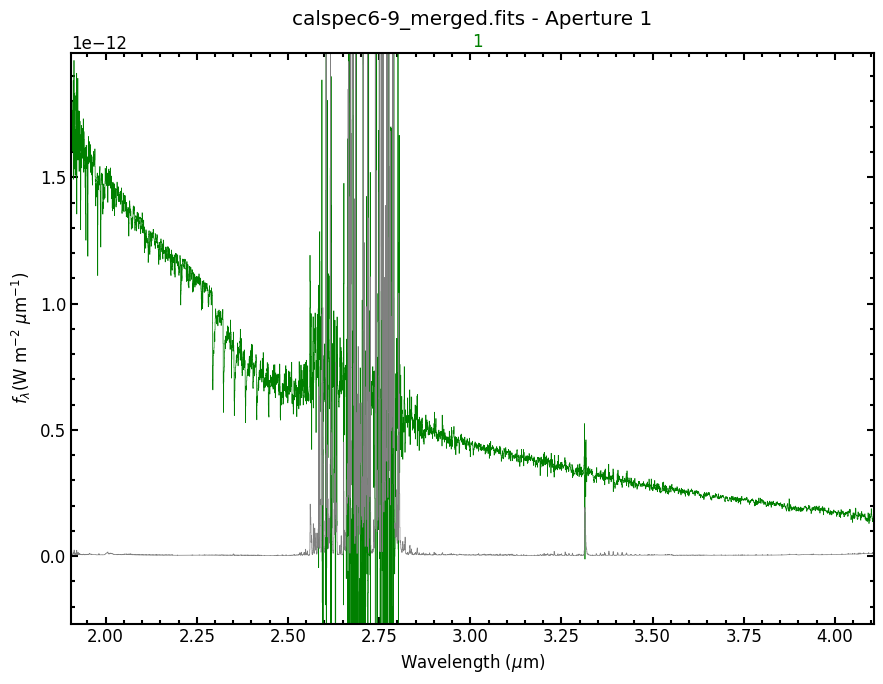


Merged spectrum saved to: /Users/ctheissen/repos/pyspextool/tests/test_data/processed/spex-LXD/proc/calspec6-9_merged.fits


In [4]:
# ============================================================================
# MERGE ORDERS - Combine multi-order spectrum into single spectrum
# ============================================================================

if input_file is not None:
    # Extract the base filename without path and extension
    basename = os.path.basename(input_file).replace('.fits', '')
    
    # Define output file name
    output_root = basename + '_merged'
    
    print(f'\nMerging orders from: {os.path.basename(input_file)}')
    print(f'Output will be saved as: {output_root}.fits\n')
    
    # Perform the merge
    ps.merge.merge(
        file=os.path.basename(input_file),    # Input file (looked up in proc_path)
        outputfile_root=output_root,           # Output file root name
        merge_apertures=None,                  # Merge all apertures (None = all)
        verbose=True,                          # Show progress messages
        qa_show=True,                          # Display QA plot showing merged result
        qa_write=True,                         # Save QA plot to disk
        qa_showblock=True                      # Block until QA plot is closed
    )
    
    print(f'\nMerged spectrum saved to: {proc_path}{output_root}.fits')
else:
    print('Skipping merge - no input file available')

## Visualize the Merged Spectrum

Let's plot the merged spectrum to see the final result. We can compare it to the individual orders to see how the merging improved the continuous coverage.

Plotting merged spectrum from: calspec6-9_merged.fits



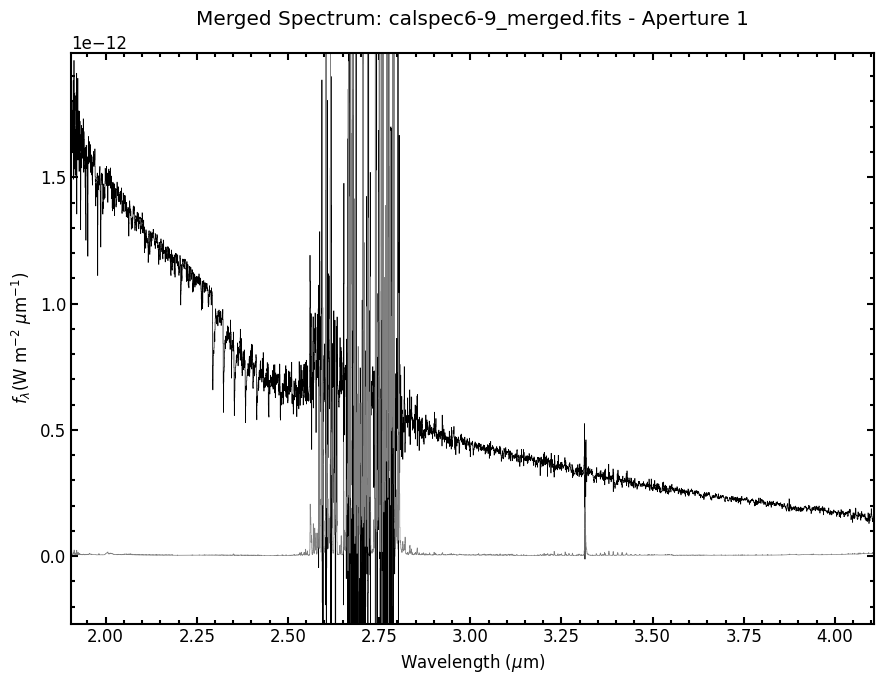

In [10]:
# ============================================================================
# PLOT THE MERGED SPECTRUM
# ============================================================================

from pyspextool.plot.plot_spectra import plot_spectra

if input_file is not None:
    # Plot the merged spectrum
    merged_file = output_root + '.fits'
    
    print(f'Plotting merged spectrum from: {merged_file}\n')
    
    # Create plot with flux and uncertainty
    ax = plot_spectra(
        proc_path + merged_file,
        title=f'Merged Spectrum: {merged_file}',
        colors='k',                    # Black line for spectrum
        ytype="flux and uncertainty",  # Show both flux and uncertainty
        order_numbers=False            # No order numbers (it's merged!)
    )
else:
    print('No merged spectrum to plot')

## Summary

In this notebook, we demonstrated how to:

1. ✓ Load a multi-order spectrum from SXD or LXD observations
2. ✓ Merge overlapping orders into a single continuous spectrum
3. ✓ Visualize the merged result

The merged spectrum is now ready for scientific analysis, such as:
- Spectral feature measurements
- Comparison with models or other data
- Publication-quality plots

## Notes:

- The merge function automatically handles overlapping regions
- Orders with higher S/N are weighted more heavily in overlaps
- QA plots show the individual orders and the merged result
- The output FITS file contains the merged spectrum with proper headers

## Next Steps:

You can now use the merged spectrum for your science analysis. For example:
- Measure spectral indices
- Fit spectral templates
- Compare with atmospheric or synthetic models
